In [19]:
# This cell imports libraries and loads the CSV, then shows a quick preview.

import pandas as pd
import numpy as np

# Change the path if needed (e.g., '/content/encoded-space_missions.csv')
csv_path = 'space_missions.csv'

df = pd.read_csv(csv_path, low_memory=False,encoding='latin1')

print(df.head(10))
print(df.shape)

     Company                                   Location        Date      Time  \
0  RVSN USSR  Site 1/5, Baikonur Cosmodrome, Kazakhstan  1957-10-04  19:28:00   
1  RVSN USSR  Site 1/5, Baikonur Cosmodrome, Kazakhstan  1957-11-03  02:30:00   
2    US Navy   LC-18A, Cape Canaveral AFS, Florida, USA  1957-12-06  16:44:00   
3       AMBA   LC-26A, Cape Canaveral AFS, Florida, USA  1958-02-01  03:48:00   
4    US Navy   LC-18A, Cape Canaveral AFS, Florida, USA  1958-02-05  07:33:00   
5       AMBA   LC-26A, Cape Canaveral AFS, Florida, USA  1958-03-05  18:27:00   
6    US Navy   LC-18A, Cape Canaveral AFS, Florida, USA  1958-03-17  12:15:00   
7       AMBA     LC-5, Cape Canaveral AFS, Florida, USA  1958-03-26  17:38:00   
8  RVSN USSR  Site 1/5, Baikonur Cosmodrome, Kazakhstan  1958-04-27  09:01:00   
9    US Navy   LC-18A, Cape Canaveral AFS, Florida, USA  1958-04-28  02:53:00   

           Rocket         Mission RocketStatus Price MissionStatus  
0  Sputnik 8K71PS       Sputnik-1      

In [23]:
# This cell performs basic cleaning, parses dates, derives Year, and creates an IsSuccess flag.
# It prints a quick sanity check of key columns at the end.

import pandas as pd
import numpy as np

# Standardize column names (strip spaces)
df.columns = [c.strip() for c in df.columns]

# Trim whitespace in string columns
str_cols = df.select_dtypes(include=['object']).columns
for c in str_cols:
    df[c] = df[c].astype(str).str.strip()

# Parse Date to datetime and extract Year
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Year'] = df['Date'].dt.year

# Normalize MissionStatus and create success flag (1 = Success; others = 0)
ms_norm = df['MissionStatus'].astype(str).str.lower()
df['IsSuccess'] = np.where(ms_norm.str.contains('success') & ~ms_norm.str.contains('partial'), 1, 0)

# Quick check
print(df[['Company', 'Date', 'Year', 'MissionStatus', 'IsSuccess']].head(10))
print(df[['Year', 'Company', 'IsSuccess']].isna().sum())
print(df.shape)
print('Cleaned and parsed basics')

     Company       Date  Year MissionStatus  IsSuccess
0  Rvsn Ussr 1957-10-04  1957       Success          1
1  Rvsn Ussr 1957-11-03  1957       Success          1
2    Us Navy 1957-12-06  1957       Failure          0
3       Amba 1958-02-01  1958       Success          1
4    Us Navy 1958-02-05  1958       Failure          0
5       Amba 1958-03-05  1958       Failure          0
6    Us Navy 1958-03-17  1958       Success          1
7       Amba 1958-03-26  1958       Success          1
8  Rvsn Ussr 1958-04-27  1958       Failure          0
9    Us Navy 1958-04-28  1958       Failure          0
Year         0
Company      0
IsSuccess    0
dtype: int64
(4630, 12)
Cleaned and parsed basics


In [24]:
# This cell aggregates annual launches and success rates by company and shows a quick preview.

import pandas as pd

grouped = (
    df.groupby(['Year', 'Company'], as_index=False)
      .agg(Launches=('IsSuccess', 'count'),
           Successes=('IsSuccess', 'sum'))
)

grouped['SuccessRate'] = grouped['Successes'] / grouped['Launches']

print(grouped.head(12))
print(grouped.shape)
print('Computed yearly success rates by company')

    Year           Company  Launches  Successes  SuccessRate
0   1957         Rvsn Ussr         2          2     1.000000
1   1957           Us Navy         1          0     0.000000
2   1958              Amba         7          3     0.428571
3   1958              Nasa         2          0     0.000000
4   1958         Rvsn Ussr         5          1     0.200000
5   1958      Us Air Force         2          1     0.500000
6   1958           Us Navy        12          1     0.083333
7   1959  General Dynamics         1          0     0.000000
8   1959              Nasa         1          0     0.000000
9   1959         Rvsn Ussr         4          2     0.500000
10  1959      Us Air Force        10          5     0.500000
11  1959           Us Navy         4          1     0.250000
(710, 5)
Computed yearly success rates by company


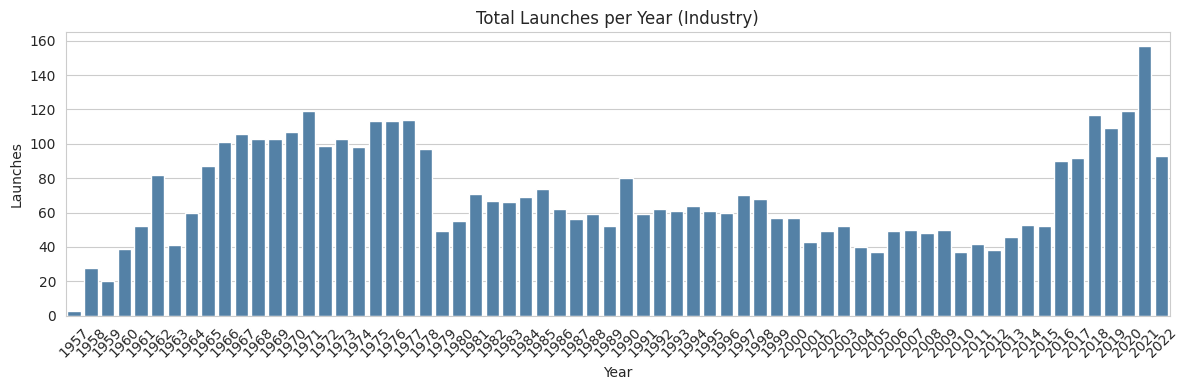

Plotted yearly total launch counts


In [25]:
# This cell plots total launch counts per year to provide sample size context.

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

launches_by_year = grouped.groupby('Year', as_index=False)['Launches'].sum().sort_values('Year')

plt.figure(figsize=(12, 4))
sns.barplot(data=launches_by_year, x='Year', y='Launches', color='steelblue')
plt.title('Total Launches per Year (Industry)')
plt.xlabel('Year')
plt.ylabel('Launches')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print('Plotted yearly total launch counts')

In [26]:
# Leaderboard for the last 5 years in the dataset with a minimum launch threshold.

import pandas as pd

last_year = grouped['Year'].max()
window_years = list(range(last_year - 4, last_year + 1))

recent = grouped[grouped['Year'].isin(window_years)].copy()

# Aggregate across the window
recent_agg = (
    recent.groupby('Company', as_index=False)
          .agg(Launches=('Launches', 'sum'),
               Successes=('Successes', 'sum'))
)
recent_agg['SuccessRate'] = recent_agg['Successes'] / recent_agg['Launches']

# Filter to companies with >= 5 launches in the window
min_launches = 5
recent_agg = recent_agg[recent_agg['Launches'] >= min_launches].copy()

# Top and bottom performers
top5 = recent_agg.sort_values('SuccessRate', ascending=False).head(5)
bottom5 = recent_agg.sort_values('SuccessRate', ascending=True).head(5)

print(top5.head())
print(bottom5.head())
print('Computed recent-years leaderboard with minimum launches filter')

        Company  Launches  Successes  SuccessRate
2   Blue Origin        14         14          1.0
28      Starsem         9          9          1.0
22          Mhi        10         10          1.0
19         Jaxa         5          5          1.0
23     Northrop        13         13          1.0
         Company  Launches  Successes  SuccessRate
17           Isa         6          1     0.166667
1          Astra         7          2     0.285714
9         Expace        14         11     0.785714
31  Virgin Orbit         5          4     0.800000
0    Arianespace        38         35     0.921053
Computed recent-years leaderboard with minimum launches filter


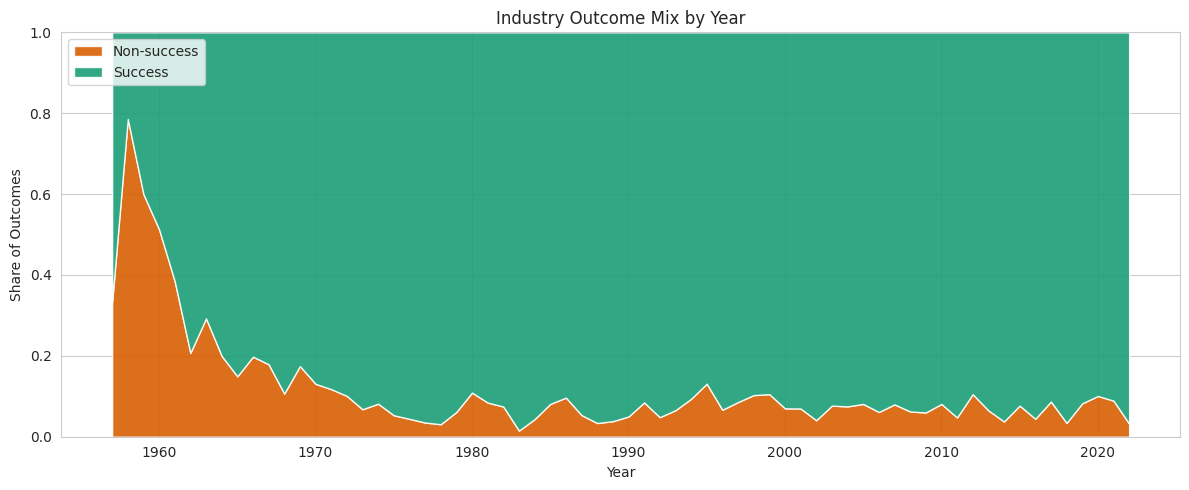

Plotted stacked outcome mix over time


In [27]:
# Stacked area chart of yearly outcome mix: Success vs Non-success.

import pandas as pd
import matplotlib.pyplot as plt

# Build yearly counts
outcome_by_year = df.groupby(['Year', 'IsSuccess'], as_index=False).size()
pivot = outcome_by_year.pivot(index='Year', columns='IsSuccess', values='size').fillna(0)
pivot = pivot.sort_index()

# Convert to percentages
pivot_pct = pivot.div(pivot.sum(axis=1), axis=0)

plt.figure(figsize=(12, 5))
plt.stackplot(pivot_pct.index, pivot_pct.get(0, pd.Series(0, index=pivot_pct.index)), pivot_pct.get(1, pd.Series(0, index=pivot_pct.index)), labels=['Non-success', 'Success'], colors=['#d95f02', '#1b9e77'], alpha=0.9)
plt.ylim(0, 1.0)
plt.title('Industry Outcome Mix by Year')
plt.xlabel('Year')
plt.ylabel('Share of Outcomes')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

print('Plotted stacked outcome mix over time')

In [28]:
# Compute Wilson 95% confidence intervals for SuccessRate in grouped.

import numpy as np
import pandas as pd

# Expect grouped to have: ['Year','Company','Launches','Successes','SuccessRate']
z = 1.96
n = grouped['Launches'].clip(lower=1)
p = (grouped['Successes'] / n).clip(0, 1)

center = (p + (z*z)/(2*n)) / (1 + (z*z)/n)
margin = (z * np.sqrt((p*(1-p)/n) + ((z*z)/(4*(n*n))))) / (1 + (z*z)/n)

grouped['CI_Lower'] = (center - margin).clip(0, 1)
grouped['CI_Upper'] = (center + margin).clip(0, 1)

print(grouped.head(12))
print('Added Wilson 95% CIs to grouped table')

    Year           Company  Launches  Successes  SuccessRate  CI_Lower  \
0   1957         Rvsn Ussr         2          2     1.000000  0.342372   
1   1957           Us Navy         1          0     0.000000  0.000000   
2   1958              Amba         7          3     0.428571  0.158217   
3   1958              Nasa         2          0     0.000000  0.000000   
4   1958         Rvsn Ussr         5          1     0.200000  0.036223   
5   1958      Us Air Force         2          1     0.500000  0.094529   
6   1958           Us Navy        12          1     0.083333  0.014865   
7   1959  General Dynamics         1          0     0.000000  0.000000   
8   1959              Nasa         1          0     0.000000  0.000000   
9   1959         Rvsn Ussr         4          2     0.500000  0.150036   
10  1959      Us Air Force        10          5     0.500000  0.236590   
11  1959           Us Navy         4          1     0.250000  0.045586   

    CI_Upper  
0   1.000000  
1   0.7

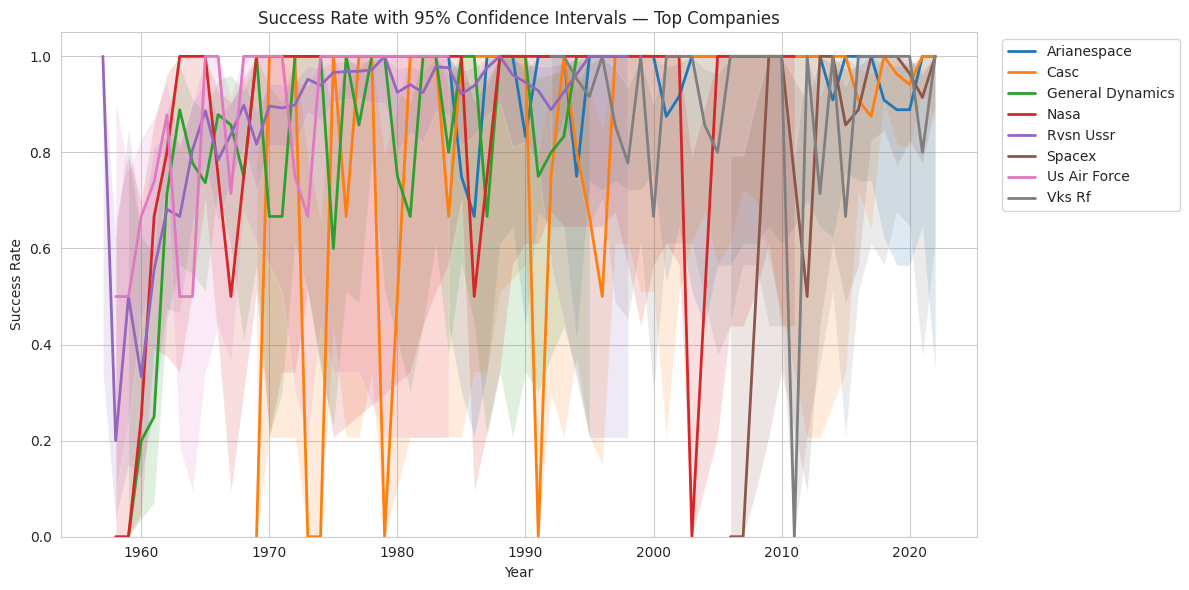

Plotted success rates with 95% CI ribbons for top companies


In [29]:
# Plot success rates with 95% CI ribbons for top companies.

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Identify top companies by total launches
company_totals_ci = grouped.groupby('Company', as_index=False)['Launches'].sum().sort_values('Launches', ascending=False)
top_companies_ci = company_totals_ci.head(8)['Company'].tolist()

top_grouped_ci = grouped[grouped['Company'].isin(top_companies_ci)].copy()
top_grouped_ci = top_grouped_ci.sort_values(['Company', 'Year'])

plt.figure(figsize=(12, 6))
sns.set_style('whitegrid')

# Plot ribbon + line per company
for company_name, sub in top_grouped_ci.groupby('Company'):
    sub = sub.sort_values('Year')
    # Ribbon
    plt.fill_between(sub['Year'], sub['CI_Lower'], sub['CI_Upper'], alpha=0.15, step=None)
    # Line
    plt.plot(sub['Year'], sub['SuccessRate'], label=company_name, linewidth=2)

plt.ylim(0, 1.05)
plt.title('Success Rate with 95% Confidence Intervals — Top Companies')
plt.ylabel('Success Rate')
plt.xlabel('Year')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

print('Plotted success rates with 95% CI ribbons for top companies')

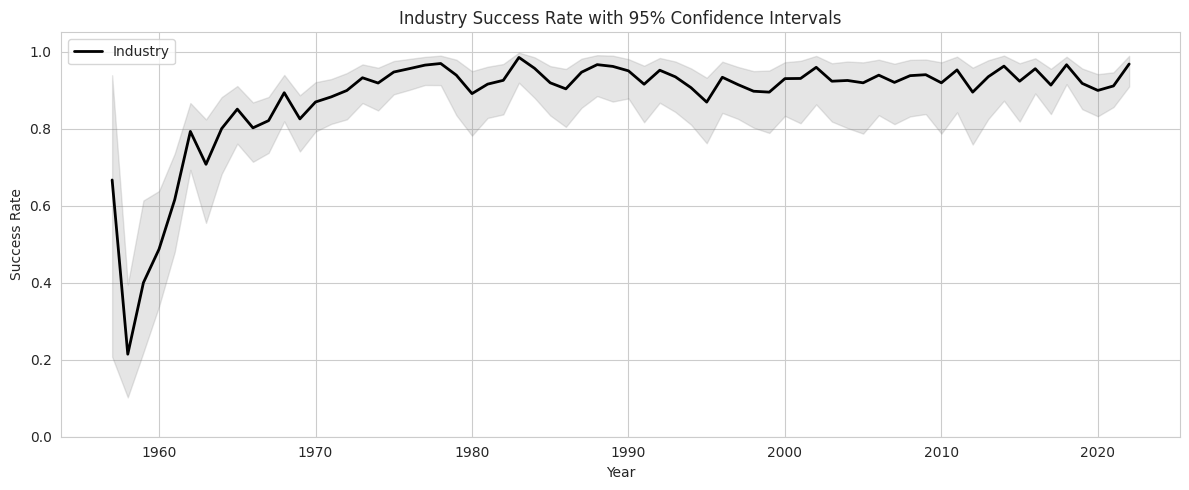

Plotted industry-wide success rate with 95% CI


In [30]:
# Industry-wide success rate and Wilson 95% CI per year.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

industry_ci = grouped.groupby('Year', as_index=False).agg(
    Launches=('Launches', 'sum'),
    Successes=('Successes', 'sum')
)
industry_ci['SuccessRate'] = industry_ci['Successes'] / industry_ci['Launches']

z = 1.96
n_i = industry_ci['Launches'].clip(lower=1)
p_i = (industry_ci['Successes'] / n_i).clip(0, 1)
center_i = (p_i + (z*z)/(2*n_i)) / (1 + (z*z)/n_i)
margin_i = (z * np.sqrt((p_i*(1-p_i)/n_i) + ((z*z)/(4*(n_i*n_i))))) / (1 + (z*z)/n_i)
industry_ci['CI_Lower'] = (center_i - margin_i).clip(0, 1)
industry_ci['CI_Upper'] = (center_i + margin_i).clip(0, 1)

plt.figure(figsize=(12, 5))
plt.fill_between(industry_ci['Year'], industry_ci['CI_Lower'], industry_ci['CI_Upper'], color='gray', alpha=0.2)
plt.plot(industry_ci['Year'], industry_ci['SuccessRate'], color='black', linewidth=2, label='Industry')
plt.ylim(0, 1.05)
plt.title('Industry Success Rate with 95% Confidence Intervals')
plt.ylabel('Success Rate')
plt.xlabel('Year')
plt.legend()
plt.tight_layout()
plt.show()

print('Plotted industry-wide success rate with 95% CI')